<a href="https://colab.research.google.com/github/kartikeyaj0/AI-Codes/blob/master/ai_hw3_maze_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this problem we will try to find optimal policy for the following grid using Q-learning:

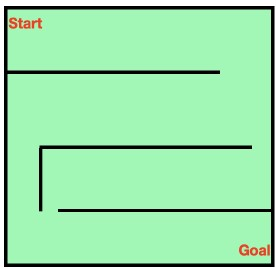


Instead of a 15x15 matrix, we will first solve it for a simplified 4x4 matrix

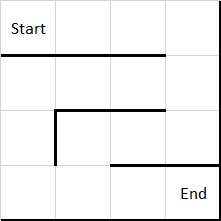

We start by importing the necessary python libraries:

In [1]:
import collections
import math
import matplotlib.pyplot as plt
import numpy as np
import random

We now initialize the environment as per the problem statement:

In [2]:
GRID_SIZE = 4
grid = [[0] * GRID_SIZE for _ in range(GRID_SIZE)]

START = (0, 0)
GOAL = (GRID_SIZE - 1, GRID_SIZE - 1)

# Action Space
A = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1),
    # 'stay': (0, 0)
}

# State Space
S = [(x, y) for x in range(GRID_SIZE) for y in range(GRID_SIZE)]

# Noise
ALPHA = 0.1

# ACTION ENUM to map each column in the Q-table to an action
A_INDEX = {
    'up': 0,
    'down': 1,
    'left': 2,
    'right': 3,
    # 'stay': 4,
}

A_LIST = list(A.keys())
EPSILON = 0.2

Our Q-table is a 2D matrix with dimensions as number of states and number of actions. We will be using row-wise indexing scheme for the grid states and use the following function to convert a 2D grid state to 1D:

In [3]:
def s_index(s):
    '''This function converts 2D index to 1D using row-wise scheme.
    : param s: A 2D grid state
    : returns: 1D index using row-wise scheme
    '''
    return s[0] * GRID_SIZE + s[1]

We now define a function which detects if our agent hit a wall:

In [4]:
# Simplified 4 x 4
def hit_wall(curr, action):
    '''This function checks if the agent hits any walls.
    : param curr: Current position of the agent
    : param action: Chosen action by the agent
    : returns: True/False Binary value to indicate if agent hits a wall
    '''
    x, y = curr

    # Check for grid boundaries
    if x == 0 and action == 'up':
        return True
    if x == GRID_SIZE - 1 and action == 'down':
        return True
    if y == 0 and action == 'left':
        return True
    if y == GRID_SIZE - 1 and action == 'right':
        return True

    # The problem statement describes 4 walls in addition to grid boundaries

    # 1st horizontal wall after 3 - (0 to 11)
    # Going down from (3, (0,11)) is not allowed
    # Coming up from (4, (0,11)) is not allowed
    if x == 0 and 0 <= y <= 2 and action == 'down':
        return True
    elif x == 1 and 0 <= y <= 2 and action == 'up':
        return True

    # 2nd horizontal wall after 7 - (2, 13)
    # Going down from (7, (2,13)) is not allowed
    # Coming up from (8, (2,13)) is not allowed
    if x == 1 and 1 <= y <= 2 and action == 'down':
        return True
    elif x == 2 and 1 <= y <= 2 and action == 'up':
        return True

    # 3rd horizontal wall after 11
    # Going down from (11, (3,14)) is not allowed
    # Coming up from (12, (3,14)) is not allowed
    if x == 2 and 2 <= y <= 3 and action == 'down':
        return True
    elif x == 3 and 2 <= y <= 3 and action == 'up':
        return True

    # vertical wall 8 to 11
    # hit on moving from ((8,11), 1) to ((8,11), 2)
    # and viceversa
    if y == 0 and x == 2 and action == 'right':
        return True
    elif y == 1 and x == 2 and action == 'left':
        return True

    # If no walls hit, return False
    return False

We assume that the environment assigns rewards using the following reward function. Note that this reward function is not visible to the agent, which can only learn from the observation samples.

In [5]:
def R(s, a):
    '''Reward function for the agent
    : param s: Current state of the agent
    : param a: Action the agent takes at the current state
    : returns: Reward for the action at current state
    '''
    if s == GOAL:
        return 0
    elif hit_wall(s, a):
        return -10000
    else:
        return -1

We define a utility function s_next_calc, which calculates the next state given current state and action:

In [6]:
def s_next_calc(s, a):
    '''This function returns the agent's next state given action
    and current state (assuming the action succeeds).
    : param s: Current position of the agent
    : param a: Chosen action by the agent
    : returns: New state coordinates in the grid
    '''
    return (s[0] + A[a][0], s[1] + A[a][1])

The agent will use the following function to stochastically perform an action and obtains the next state and the associated reward.

In [7]:
def take_step(s, a):
    '''This function stochastically performs the action 'a' on the given
    state s.
    : param s: Current position of the agent
    : param a: Chosen action by the agent
    : returns: New state coordinates in the grid and the observed reward
    '''
    # Given curr state s and an action a, return the next state
    
    action_list = [a]
    cum_prob_list = [1 - ALPHA]
    for action in A:
        if action != a:
            action_list.append(action)
            cum_prob_list.append(cum_prob_list[-1] + ALPHA/(len(A) - 1))
    action_taken = random.choices(action_list, cum_weights = cum_prob_list)[0]
    r = R(s, action_taken)
    if r == -10000: # hit wall
        s_next = s
    else:
        s_next = s_next_calc(s, action_taken)
    return s_next, r
    

We will use the following function to choose an action for the state from Q using a basic epsilon-greedy implementation:

In [32]:
def choose_action_epsilon(s, episode):
    # Using a fixed epsilon value
    # TODO(KJ): add a decresing epsilon
    if random.uniform(0, 1) < EPSILON/(episode+1):
        return random.choice(A_LIST)
    return A_LIST[np.argmax(Q[s_index(s)])]
    

The agent uses the following function for Q-Learning:

In [33]:
def q_learning(gamma, episodes):
    '''This function implements the Q-learning algorithm
    : param gamma: Discounting factor
    : param episodes: Number of episodes to be run
    '''
    r_list = []
    for episode in range(episodes):
        s = START
        r_sum = 0
        while s != GOAL:
            # Choose a random action for the current state s
            # a = random.choice(A_LIST)
            a = choose_action_epsilon(s, episode)
            # Take the random action with a transition error ALPHA
            s_next, r = take_step(s, a)
            # Update Q table
            max_q_next = max(
                Q[s_index(s_next)][A_INDEX[action]] for action in A_LIST)
            Q[s_index(s)][A_INDEX[a]] = Q[s_index(s)][A_INDEX[a]] + ALPHA * (
                r + gamma * max_q_next - Q[s_index(s)][A_INDEX[a]])
            s = s_next
            r_sum += r
            if s == GOAL:
                # print('episode {} reached goal state'.format(episode))
                break
        r_list.append(r_sum)
    return r_list

#TODO: learning rate should change within an episode. not fixed


In [23]:
def plot_policy_from_qtable(Q):
    '''This function plots the policy learned from Q-Learning
    : param Q: Q-table
    '''
    policy = {(r//4, r%4): A_LIST[np.argmax(Q[r])] for r in range(
                                                        GRID_SIZE * GRID_SIZE)}
    plt.imshow(np.max(Q, axis = 1).reshape(4,4))
    quiver_action_dict = {
        'up': [0, 1],
        'down': [0, -1],
        'left': [-1, 0],
        'right': [1, 0],
        'stay': [0, 0]
    }
    for k, v in policy.items():
        plt.quiver(k[1], k[0],
                  quiver_action_dict[v][0], quiver_action_dict[v][1])

We can now run the Q-learning algorithm:

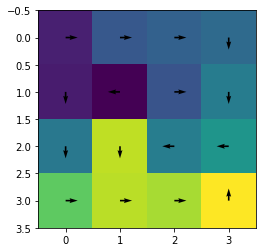

In [37]:
# Q - Table
Q = [[0] * len(A) for _ in range(GRID_SIZE * GRID_SIZE)]
r_list = q_learning(0.9, 500)
plot_policy_from_qtable(Q)

We can also plot the rewards obtained in each episode as follows.

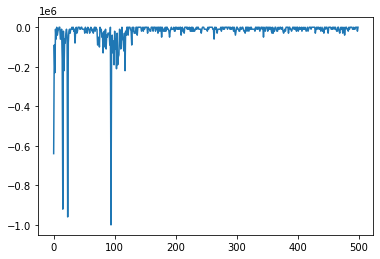

In [39]:
plt.plot(range(500), r_list)

We can see the rewards start improving after the first few iterations and tend to reach an asymptote near 0. Due to the stochastic nature of the problem, we will collect the rewards for 5 runs and plot them together to see any underlying patterns.

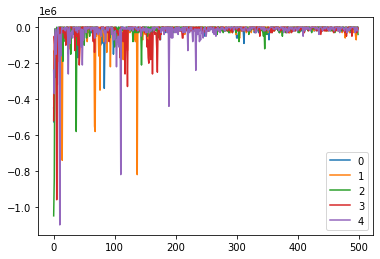

In [43]:
# Q - Table
for i in range(5):
    Q = [[0] * len(A) for _ in range(GRID_SIZE * GRID_SIZE)]
    plt.plot(range(500), q_learning(0.9, 500), label=i)
plt.legend()
plt.show()

We see the common pattern that the rewards are initially bad, but as the number of episodes increases, the agent gets better and the reward reach an asymptote.